# <center> Classify legal Document </center>

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten, Dropout, concatenate
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model
from keras.callbacks import EarlyStopping
import gensim
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
import codecs
import matplotlib.pyplot as plt
from subprocess import check_output
import os

Using TensorFlow backend.


In [18]:
#nltk.download('stopwords')

In [10]:
stop_words = set(nltk.corpus.stopwords.words('french'))

### Cleaning Text

##### standardisation

In [7]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

In [25]:
train.fillna('_NA_')
train = standardize_text(train, "article")
train.to_csv("train_clean_data.csv")
train.head()

,article,acpa,concdel,dcppc,styx,danais,doris
0,"cour d'appel, lyon, chambre sociale c, 20 mai ...",0.0,0.0,0.0,0.0,1.0,0.0
1,"cour d'appel, paris, p le 4, chambre 1, 13 mai...",1.0,0.0,0.0,0.0,0.0,0.0
2,"cour d'appel, lyon, 8e chambre, 8 mars 2016 ...",1.0,0.0,0.0,0.0,0.0,0.0
3,"cour d'appel, n mes, 2e chambre commerciale, s...",0.0,0.0,0.0,0.0,1.0,0.0
4,"cour d'appel, colmar, chambre sociale, 14 juin...",0.0,0.0,0.0,1.0,0.0,0.0


In [26]:
#test 
test1=test.drop(columns="classe")
test1.fillna('_NA_')
test1 = standardize_text(test1, "article")
test1.to_csv("test_clean_data.csv")
test1.head()

,article
0,"cour d'appel, douai, 1re chambre, 1re section,..."
1,page\npage\ndocument 16 de 115\ncour d'appel\n...
2,"cour d'appel, pau, 1re chambre, 7 septembre 20..."
3,"cour d'appel, aix en provence, 8e chambre c, 2..."
4,"cour d'appel, poitiers, 3e chambre civile, 1er..."


##### Tokenizing Text

In [27]:
tokenizer = RegexpTokenizer(r'\w+')
clean_train_comments = pd.read_csv("train_clean_data.csv")
clean_train_comments['article'] = clean_train_comments['article'].astype('str') 
clean_train_comments.dtypes
clean_train_comments["tokens"] = clean_train_comments["article"].apply(tokenizer.tokenize)
# supprimer Stop Words
clean_train_comments["tokens"] = clean_train_comments["tokens"].apply(lambda vec: [word for word in vec if word not in stop_words])
#Filtrer Punctuation et chiffres 
clean_train_comments["tokens"] = clean_train_comments["tokens"].apply(lambda vec: [word for word in vec if word.isalpha() ])
#Stemming ( animaux ==> animal / appels ==> appel)
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
clean_train_comments["tokens"]  = clean_train_comments["tokens"].apply(lambda vec: [porter.stem(word) for word in vec  ])
clean_train_comments.drop(columns="Unnamed: 0",inplace=True)


In [28]:
clean_train_comments.head()

,article,acpa,concdel,dcppc,styx,danais,doris,tokens
0,"cour d'appel, lyon, chambre sociale c, 20 mai ...",0.0,0.0,0.0,0.0,1.0,0.0,"[cour, appel, lyon, chambr, social, mai, cour,..."
1,"cour d'appel, paris, p le 4, chambre 1, 13 mai...",1.0,0.0,0.0,0.0,0.0,0.0,"[cour, appel, pari, p, chambr, mai, cour, appe..."
2,"cour d'appel, lyon, 8e chambre, 8 mars 2016 ...",1.0,0.0,0.0,0.0,0.0,0.0,"[cour, appel, lyon, chambr, mar, cour, appel, ..."
3,"cour d'appel, n mes, 2e chambre commerciale, s...",0.0,0.0,0.0,0.0,1.0,0.0,"[cour, appel, chambr, commercial, section, b, ..."
4,"cour d'appel, colmar, chambre sociale, 14 juin...",0.0,0.0,0.0,1.0,0.0,0.0,"[cour, appel, colmar, chambr, social, juin, co..."


In [29]:
clean_test_comments = pd.read_csv("test_clean_data.csv")
clean_test_comments['article'] = clean_test_comments['article'].astype('str') 
clean_test_comments.dtypes
clean_test_comments["tokens"] = clean_test_comments["article"].apply(tokenizer.tokenize)
clean_test_comments["tokens"] = clean_test_comments["tokens"].apply(lambda vec: [word for word in vec if word not in stop_words])
clean_test_comments["tokens"] = clean_test_comments["tokens"].apply(lambda vec: [word for word in vec if word.isalpha() ])
clean_test_comments.drop(columns="Unnamed: 0",inplace=True)
clean_test_comments.head()

,article,tokens
0,"cour d'appel, douai, 1re chambre, 1re section,...","[cour, appel, douai, chambre, section, f, vrie..."
1,page\npage\ndocument 16 de 115\ncour d'appel\n...,"[page, page, document, cour, appel, poitiers, ..."
2,"cour d'appel, pau, 1re chambre, 7 septembre 20...","[cour, appel, pau, chambre, septembre, cour, a..."
3,"cour d'appel, aix en provence, 8e chambre c, 2...","[cour, appel, aix, provence, chambre, mai, cou..."
4,"cour d'appel, poitiers, 3e chambre civile, 1er...","[cour, appel, poitiers, chambre, civile, juin,..."


In [30]:
all_training_words = [word for tokens in clean_train_comments["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in clean_train_comments["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

626413 words total, with a vocabulary size of 11834
Max sentence length is 10912


In [31]:
all_test_words = [word for tokens in clean_test_comments["tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in clean_test_comments["tokens"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(TEST_VOCAB)))
print("Max sentence length is %s" % max(test_sentence_lengths))

168246 words total, with a vocabulary size of 8911
Max sentence length is 6716


## Word2vec + Embedding

Word2vec est un modèle qui a été pré-formé sur un très grand corpus et fournit des incorporations qui mappent des mots similaires les uns aux autres

In [32]:
word2vec_path = "GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

/home/amal/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [33]:
training_embeddings = get_word2vec_embeddings(word2vec, clean_train_comments, generate_missing=True)
# test_embeddings = get_word2vec_embeddings(word2vec, clean_test_comments, generate_missing=True)

In [34]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(clean_train_comments["article"].tolist())
training_sequences = tokenizer.texts_to_sequences(clean_train_comments["article"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

Found 21922 unique tokens.
(21923, 300)


In [35]:
test_sequences = tokenizer.texts_to_sequences(clean_test_comments["article"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [36]:
tokenizer = RegexpTokenizer(r'\w+')
clean_train_comments = pd.read_csv("train_clean_data.csv")
clean_train_comments['article'] = clean_train_comments['article'].astype('str') 
clean_train_comments.dtypes
clean_train_comments["tokens"] = clean_train_comments["article"].apply(tokenizer.tokenize)
# supprimer Stop Words
clean_train_comments["tokens"] = clean_train_comments["tokens"].apply(lambda vec: [word for word in vec if word not in stop_words])
#Filtrer Punctuation et chiffres 
clean_train_comments["tokens"] = clean_train_comments["tokens"].apply(lambda vec: [word for word in vec if word.isalpha() ])
#Stemming ( animaux ==> animal / appels ==> appel)
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
clean_train_comments["tokens"]  = clean_train_comments["tokens"].apply(lambda vec: [porter.stem(word) for word in vec  ])
clean_train_comments.drop(columns="Unnamed: 0",inplace=True)


In [37]:
clean_train_comments.head()

,article,acpa,concdel,dcppc,styx,danais,doris,tokens
0,"cour d'appel, lyon, chambre sociale c, 20 mai ...",0.0,0.0,0.0,0.0,1.0,0.0,"[cour, appel, lyon, chambr, social, mai, cour,..."
1,"cour d'appel, paris, p le 4, chambre 1, 13 mai...",1.0,0.0,0.0,0.0,0.0,0.0,"[cour, appel, pari, p, chambr, mai, cour, appe..."
2,"cour d'appel, lyon, 8e chambre, 8 mars 2016 ...",1.0,0.0,0.0,0.0,0.0,0.0,"[cour, appel, lyon, chambr, mar, cour, appel, ..."
3,"cour d'appel, n mes, 2e chambre commerciale, s...",0.0,0.0,0.0,0.0,1.0,0.0,"[cour, appel, chambr, commercial, section, b, ..."
4,"cour d'appel, colmar, chambre sociale, 14 juin...",0.0,0.0,0.0,1.0,0.0,0.0,"[cour, appel, colmar, chambr, social, juin, co..."


In [38]:
clean_test_comments = pd.read_csv("test_clean_data.csv")
clean_test_comments['article'] = clean_test_comments['article'].astype('str') 
clean_test_comments.dtypes
clean_test_comments["tokens"] = clean_test_comments["article"].apply(tokenizer.tokenize)
clean_test_comments["tokens"] = clean_test_comments["tokens"].apply(lambda vec: [word for word in vec if word not in stop_words])
clean_test_comments["tokens"] = clean_test_comments["tokens"].apply(lambda vec: [word for word in vec if word.isalpha() ])
clean_test_comments.drop(columns="Unnamed: 0",inplace=True)
clean_test_comments.head()

,article,tokens
0,"cour d'appel, douai, 1re chambre, 1re section,...","[cour, appel, douai, chambre, section, f, vrie..."
1,page\npage\ndocument 16 de 115\ncour d'appel\n...,"[page, page, document, cour, appel, poitiers, ..."
2,"cour d'appel, pau, 1re chambre, 7 septembre 20...","[cour, appel, pau, chambre, septembre, cour, a..."
3,"cour d'appel, aix en provence, 8e chambre c, 2...","[cour, appel, aix, provence, chambre, mai, cou..."
4,"cour d'appel, poitiers, 3e chambre civile, 1er...","[cour, appel, poitiers, chambre, civile, juin,..."


In [39]:
all_training_words = [word for tokens in clean_train_comments["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in clean_train_comments["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

626413 words total, with a vocabulary size of 11834
Max sentence length is 10912


In [40]:
all_test_words = [word for tokens in clean_test_comments["tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in clean_test_comments["tokens"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(TEST_VOCAB)))
print("Max sentence length is %s" % max(test_sentence_lengths))

168246 words total, with a vocabulary size of 8911
Max sentence length is 6716


## CNN

In [41]:
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)

    l_merge = keras.layers.Concatenate( axis=1)(convs)

    # add a 1D convnet with global maxpooling
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)

    if extra_conv==True:
        x = Dropout(0.5)(l_merge)  
    else:
        x = Dropout(0.5)(pool)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    # Finally, we feed the output into a Sigmoid layer.
    # The reason why sigmoid is used is because we are trying to achieve a binary classification(1,0) 
    # for each of the 6 labels, and the sigmoid function will squash the output between the bounds of 0 and 1.
    preds = Dense(labels_index, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    model.summary()
    return model

In [42]:
x_train = train_cnn_data
y_tr = y_train

In [43]:
model1 = ConvNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, 
                len(list(label_names)), False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 300)     6576900     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 198, 128)     115328      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)    

In [44]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

Now let's train our Neural Network

In [45]:
hist = model1.fit(x_train, y_tr, epochs=num_epochs, callbacks=callbacks_list, validation_split=0.1, shuffle=True, batch_size=batch_size)

Instructions for updating:
Use tf.cast instead.
Train on 324 samples, validate on 36 samples
Epoch 1/8
324/324 [==============================] - 8s 24ms/step - loss: 0.9402 - acc: 0.5643 - val_loss: 0.9222 - val_acc: 0.8333
Epoch 2/8
324/324 [==============================] - 3s 9ms/step - loss: 1.2563 - acc: 0.7932 - val_loss: 0.4965 - val_acc: 0.8426
Epoch 3/8
324/324 [==============================] - 2s 7ms/step - loss: 0.7937 - acc: 0.7706 - val_loss: 0.3953 - val_acc: 0.8333
Epoch 4/8
324/324 [==============================] - 3s 8ms/step - loss: 0.5068 - acc: 0.8025 - val_loss: 0.4121 - val_acc: 0.8333
Epoch 5/8
324/324 [==============================] - 3s 8ms/step - loss: 0.4532 - acc: 0.8122 - val_loss: 0.4261 - val_acc: 0.8333
Epoch 6/8
324/324 [==============================] - 3s 8ms/step - loss: 0.4530 - acc: 0.8318 - val_loss: 0.4062 - val_acc: 0.8333
Epoch 7/8
324/324 [==============================] - 3s 9ms/step - loss: 0.4361 - acc: 0.8338 - val_loss: 0.3672 - val_a

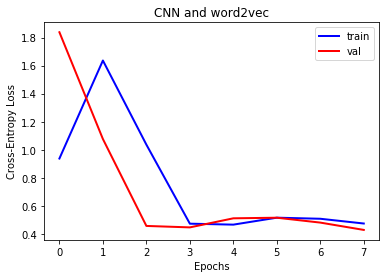

In [44]:

plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN and word2vec')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

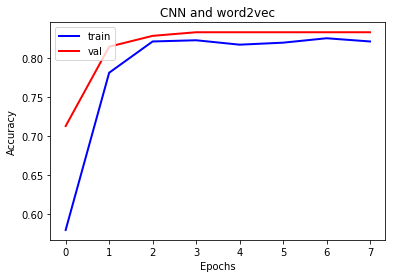

In [45]:
plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('CNN and word2vec')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [18]:
from keras.models import load_model

#model1.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
#del model1  # deletes the existing model

# returns a compiled model
# identical to the previous one
model1 = load_model('my_model.h5')

W0903 09:15:29.234261  1520 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0903 09:15:29.621486  1520 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0903 09:15:29.953207  1520 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0903 09:15:30.001080  1520 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0903 09:15:30.003075  1520 deprecation_wrapper.py:119] From C:\ProgramData\An

In [19]:
model1

# Input

In [3]:
p = open('acpa/CALYO1406491.txt')
ps = {'article': [p.read()]}
dChercher=pd.DataFrame(data=ps)

In [4]:
dChercher

,article
0,"Cour d'appel, Lyon, 8e chambre, 8 Mars 2016 – ..."


In [8]:
dChercher.fillna('_NA_')
test_comments = standardize_text(dChercher, "article")
test_comments.head()

,article
0,"cour d'appel, lyon, 8e chambre, 8 mars 2016 ..."


In [11]:
tokenizer = RegexpTokenizer(r'\w+')
clean_test_comments = test_comments
clean_test_comments['article'] = clean_test_comments['article'].astype('str') 
clean_test_comments.dtypes
clean_test_comments["tokens"] = clean_test_comments["article"].apply(tokenizer.tokenize)
clean_test_comments["tokens"] = clean_test_comments["tokens"].apply(lambda vec: [word for word in vec if word not in stop_words])

clean_test_comments.head()

,article,tokens
0,"cour d'appel, lyon, 8e chambre, 8 mars 2016 ...","[cour, appel, lyon, 8e, chambre, 8, mars, 2016..."


In [14]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, lower=True, char_level=False)
test_sequences = tokenizer.texts_to_sequences(clean_test_comments["article"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [20]:
y_test = model1.predict(test_cnn_data, batch_size=1024, verbose=1)

1/1 [==============================] - 1s 1s/step


In [26]:
x=y_test
x

array([[0.49677664, 0.4957913 , 0.4965474 , 0.49538243, 0.49927068,
        0.4953103 ]], dtype=float32)

In [73]:
submission_df = pd.DataFrame(columns=['id'] + label_names)
submission_df['id'] = 0 
submission_df[label_names] = y_test 
submission_df

,id,acpa,concdel,dcppc,styx,danais,doris
0,NaN,0.495989,0.495238,0.49748,0.496869,0.498896,0.494954


# dynamic

In [46]:
import sys
import os

import re
import collections
import itertools
import pickle
sys.path.append('../../lib')

import numpy as np
import pandas as pd
import gc
import random
import smart_open
import h5py
import csv
import json
import functools
import time
import string

import datetime as dt
from tqdm import tqdm_notebook as tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


random_state_number = 967898

import tensorflow as tf
from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
get_available_gpus()

[]

In [16]:
x_train = train_cnn_data
y_tr = y_train

NameError: name 'y_train' is not defined

In [48]:
from tensorflow.python.keras.models import Sequential
import tensorflow.python.keras
import tensorflow.contrib.keras as keras

In [49]:
from keras.layers import Conv1D, MaxPool1D, Conv2D, MaxPool2D, ZeroPadding1D

In [50]:
from utils import KMaxPooling

In [51]:

from utils import Folding

In [52]:
import tensorflow.contrib.keras as keras
import tensorflow as tf

from keras import backend as K

from keras.engine import Layer, InputSpec, InputLayer

from keras.models import Model, Sequential

from keras.layers import Dropout, Embedding, concatenate
from keras.layers import Conv1D, MaxPool1D, Conv2D, MaxPool2D, ZeroPadding1D
from keras.layers import Dense, Input, Flatten, BatchNormalization
from keras.layers import Bidirectional, TimeDistributed
from keras.layers import SimpleRNN, LSTM, GRU, Lambda, Permute

from keras.layers.core import Reshape, Activation
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard
from keras.constraints import maxnorm
from keras.regularizers import l2

In [53]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

In [54]:
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = KMaxPooling(k=5, axis=1)(l_conv)
        convs.append(l_pool)

    #l_merge = keras.layers.Concatenate( axis=1)(convs)

    # add a 1D convnet with global maxpooling
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = KMaxPooling(k=5, axis=1)(conv)

    #if extra_conv==True:
        #x = Dropout(0.5)(l_merge)  
    #else:
    x = Dropout(0.5)(pool)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    # Finally, we feed the output into a Sigmoid layer.
    # The reason why sigmoid is used is because we are trying to achieve a binary classification(1,0) 
    # for each of the 6 labels, and the sigmoid function will squash the output between the bounds of 0 and 1.
    preds = Dense(labels_index, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    model.summary()
    return model

In [55]:
model = ConvNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, 
                len(list(label_names)), False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 200, 300)          6553200   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 198, 128)          115328    
_________________________________________________________________
k_max_pooling_4 (KMaxPooling (None, 5, 128)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 128)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               82048     
__________

Now let's train our Neural Network

In [56]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

Now let's train our Neural Network

In [57]:
hist = model.fit(x_train, y_tr, epochs=num_epochs, callbacks=callbacks_list, validation_split=0.1, shuffle=True, batch_size=batch_size)

Train on 324 samples, validate on 36 samples
Epoch 1/8
324/324 [==============================] - 3s 9ms/step - loss: 0.7877 - acc: 0.6317 - val_loss: 0.4673 - val_acc: 0.8333
Epoch 2/8
324/324 [==============================] - 1s 3ms/step - loss: 0.5451 - acc: 0.8056 - val_loss: 0.4453 - val_acc: 0.8333
Epoch 3/8
324/324 [==============================] - 1s 3ms/step - loss: 0.5093 - acc: 0.8133 - val_loss: 0.4131 - val_acc: 0.8148
Epoch 4/8
324/324 [==============================] - 1s 2ms/step - loss: 0.4518 - acc: 0.8117 - val_loss: 0.4143 - val_acc: 0.8148
Epoch 5/8
324/324 [==============================] - 1s 3ms/step - loss: 0.4484 - acc: 0.8035 - val_loss: 0.4190 - val_acc: 0.8333
Epoch 6/8
324/324 [==============================] - 1s 2ms/step - loss: 0.4399 - acc: 0.8189 - val_loss: 0.4169 - val_acc: 0.8426
Epoch 7/8
324/324 [==============================] - 1s 2ms/step - loss: 0.4262 - acc: 0.8153 - val_loss: 0.4122 - val_acc: 0.8333
Epoch 00007: early stopping


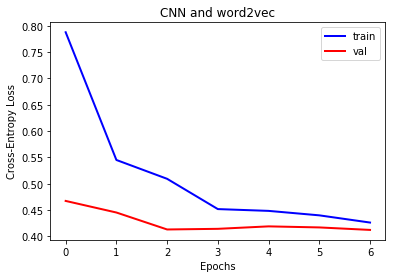

In [58]:

plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN and word2vec')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

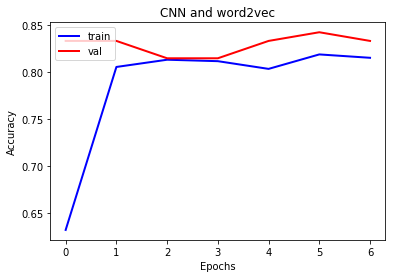

In [59]:
plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('CNN and word2vec')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()